In [5]:
import os
import matplotlib.pyplot as plt
print(os.getcwd())  #I'm just gettig how to access the file here

/home/jovyan/work/data-driven-decisions/data-driven-decisions/module_04


In [6]:
##LOAD MATERIALS

import pandas as pd


def load_material_properties(filename='./materials.csv'):
    try:
        return pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Error: The file {filename} does not exist.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file {filename} is empty or not formatted correctly.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

def get_material_properties(materials_df, material, method):
    row = materials_df[(materials_df['material'] == material) & (materials_df['method'] == method)]
    if not row.empty:
        properties = {
            'youngs_modulus_MPa': row['youngs_modulus_MPa'].values[0],
            'yield_strength_MPa': row['yield_strength_MPa'].values[0],
            'porosity_range': [float(x) for x in row['porosity_range'].values[0].split(',')]
        }
        return properties
    else:
        return None

# Example usage:
materials_df = load_material_properties()
print(materials_df)
material_properties = get_material_properties(materials_df, 'Steel', 'Casting')
print(material_properties)


    material             method  youngs_modulus_MPa  yield_strength_MPa  \
0      Steel            Casting              210000                 550   
1   Aluminum        3D Printing               70000                 250   
2   Titanium          Machining              116000                 880   
3    Polymer  Injection Molding                2500                  50   
4  Composite        3D Printing               70000                 600   

  porosity_range  
0      0.02,0.05  
1      0.05,0.15  
2      0.01,0.03  
3      0.02,0.04  
4       0.03,0.1  
{'youngs_modulus_MPa': 210000, 'yield_strength_MPa': 550, 'porosity_range': [0.02, 0.05]}


In [7]:
##SIMULATION

import numpy as np
from numpy.random import default_rng
rng = default_rng(42)
def run_monte_carlo_simulation(N_pores, 
                               volume_material, 
                               material_properties, 
                               mean_pore_size):
    """
    Simulate the effects of porosity on a material property.

    Args:
    material (dict): A dictionary containing the material properties and porosity range.
    num_simulations (int): The number of simulations to run.

    Returns:
    np.array: An array of simulated values.
    """

    
    V = volume_material   #volume of material
    ws = rng.lognormal(mean = mean_pore_size, sigma = 0.1, size = N_pores)  #mean a determines the average size of the pore
    #plt.hist(ws)
    #print(np.mean(ws), np.std(ws))
    #print(np.sum(4/3*np.pi*ws**3)) #volume of all the pores
    porosity = np.sum(4/3*np.pi*ws**3)/V
    #print('porosity = ',np.sum(4/3*np.pi*ws**3)/V)  #porosity given by the ratio of pore volume to starting volume
    
    average_pore_size = np.mean(ws)
    std_pore_size = np.std(ws)
    
    return porosity, ws

(array([  3.,  31., 114., 209., 289., 208.,  88.,  47.,   8.,   3.]),
 array([0.69430684, 0.76229803, 0.83028922, 0.89828041, 0.96627159,
        1.03426278, 1.10225397, 1.17024516, 1.23823635, 1.30622753,
        1.37421872]),
 <BarContainer object of 10 artists>)

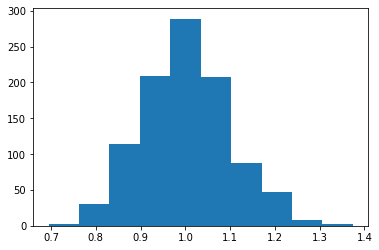

In [8]:
plt.hist(
    #np.log(
    rng.lognormal(np.log(1), 
                  0.1, 
                  1000)
    #)
)

0.00044186824370725565


(array([ 4.,  9., 18., 24., 20., 12., 10.,  1.,  0.,  2.]),
 array([0.80410855, 0.8561326 , 0.90815666, 0.96018071, 1.01220477,
        1.06422882, 1.11625287, 1.16827693, 1.22030098, 1.27232504,
        1.32434909]),
 <BarContainer object of 10 artists>)

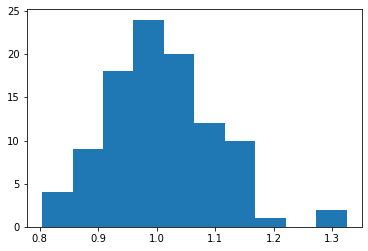

In [9]:
porosity, ws = run_monte_carlo_simulation(100, 1000000, material_properties, np.log(1))
print(porosity)
plt.hist(ws)

In [10]:
def calculate_reduced_life(porosity_factor, ws, expected_life):
    """
    Calculate reduced fatigue life using Goodman, Gerber, and Paris equations.

    Args:
    porosity_factor (float): The porosity factor (0 to 1 scale, where 1 is highly porous).
    expected_life (float): The baseline expected fatigue life without porosity.

    Returns:
    dict: A dictionary containing reduced life estimations according to different models.
    """

    sigma_ut = 400  # Ultimate tensile strength in MPa
    sigma_e = 200  # Endurance limit in MPa
    C = 1e-12  # Paris' law constant C
    m = 3.1  # Paris' law constant m
    sigma = 100  # Assumed nominal stress in MPa, example value
    Y = 1.12  # Geometric factor for an internal crack, approx. value


    # Adjust properties based on porosity
    adjusted_sigma_e = sigma_e * (1 - porosity_factor)
    adjusted_sigma_ut = sigma_ut * (1 - porosity_factor)

    # Goodman's reduction
    goodman_life = expected_life * (1 - porosity_factor)

    # Gerber's reduction
    gerber_life = expected_life * (1 - porosity_factor**2)

    # Paris' Law (simplistic approach for demonstration)
    #a = average_pore_size / 2  # Convert diameter to radius for crack length approximation
    Delta_K = np.max(Y * sigma * np.sqrt(np.pi * ws))  # Calculate Delta K using the formula

    # Calculate Paris' Law factor
    paris_factor = C * (Delta_K**m)
    
    da = 0.0001  # Small increment in crack length
    N = 0  # Initialize cycle count
    a = np.max(ws)  # Initial crack length
    a_c = 3.5

    while a < a_c:
        #Delta_K = Y * sigma * np.sqrt(np.pi * a)
        da = C * (Delta_K**m)*1
        a += da  # Increment crack length
        Delta_K = np.max(Y * sigma * np.sqrt(np.pi * (a)))
        N += 1  # Increment cycle count

    
    return N

In [11]:
from scipy.optimize import fsolve

fsolve(lambda V: run_monte_carlo_simulation(100, V, material_properties, np.log(1))[0] - 0.01, 1000)

array([999.99917079])

In [12]:
run_monte_carlo_simulation(100, 8000, material_properties, np.log(1))[0] - 0.01

0.04618731705708577

In [13]:
##USE ABOVE FUNCTIONS/CODE BLOCKS

materials_df = load_material_properties()
material_properties = get_material_properties(materials_df, 'Polymer', 'Injection Molding')

porosity, ws = run_monte_carlo_simulation(100, 1000000,material_properties, np.log(1))
porosity, ws

(0.000428781158614649,
 array([0.95637332, 1.10298384, 1.02851634, 0.93262161, 0.91704935,
        0.84810602, 1.02950007, 0.96516254, 0.78881808, 0.94783818,
        0.91383669, 1.17066008, 0.84343043, 0.86577079, 1.11739151,
        1.14531111, 0.92820906, 0.93874765, 1.06356188, 0.79238335,
        0.83017449, 0.97231705, 1.16764518, 0.95736266, 1.01014479,
        1.12005627, 1.23452771, 0.94394739, 0.99831774, 1.19986077,
        0.85879939, 1.10822331, 0.90318168, 1.01029992, 0.97603005,
        0.90864467, 0.90636771, 1.02802701, 1.10467805, 0.98711017,
        1.00703595, 1.05878011, 0.90740911, 1.0767737 , 1.08538451,
        1.29740048, 0.96308807, 0.95522518, 1.07993039, 1.08535858,
        0.94789768, 0.96048562, 1.05560397, 0.92057351, 0.95977788,
        1.00899953, 1.10472216, 0.94133155, 0.83173746, 0.82558773,
        0.88166659, 0.87693994, 0.98465783, 0.88790723, 0.93213698,
        0.92551162, 0.95690536, 1.14139413, 1.06843478, 1.00161424,
        0.95494395, 0.957

In [14]:
expected_life = 1e6  # 1 million cycles without porosity
reduced_life = calculate_reduced_life(porosity, ws, expected_life)
print("Porosity:", porosity)
print("Reduced Fatigue Life (Cycles):", reduced_life)

Porosity: 0.000428781158614649
Reduced Fatigue Life (Cycles): 49912


V (mm^3): 100   Mean Pore Radii(mm): 0.1 
    Porosity: 0.0003919668302879398
    Fatigue Life (Cycles): 392589 

V (mm^3): 100   Mean Pore Radii(mm): 0.2 
    Porosity: 0.003707601934192492
    Fatigue Life (Cycles): 243137 

V (mm^3): 100   Mean Pore Radii(mm): 0.3 
    Porosity: 0.011871833201398183
    Fatigue Life (Cycles): 179491 

V (mm^3): 100   Mean Pore Radii(mm): 0.4 
    Porosity: 0.028881744367874683
    Fatigue Life (Cycles): 132718 

V (mm^3): 500   Mean Pore Radii(mm): 0.1 
    Porosity: 9.245401963855798e-05
    Fatigue Life (Cycles): 394347 

V (mm^3): 500   Mean Pore Radii(mm): 0.2 
    Porosity: 0.0006797601206136953
    Fatigue Life (Cycles): 236893 

V (mm^3): 500   Mean Pore Radii(mm): 0.3 
    Porosity: 0.0023220710393309185
    Fatigue Life (Cycles): 184518 

V (mm^3): 500   Mean Pore Radii(mm): 0.4 
    Porosity: 0.005165209967096702
    Fatigue Life (Cycles): 149456 

V (mm^3): 1000   Mean Pore Radii(mm): 0.1 
    Porosity: 4.097516247352117e-05
    Fatigue L

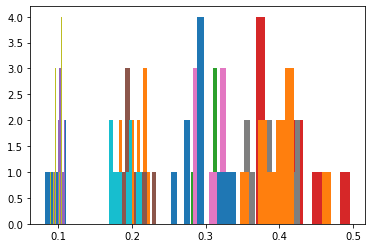

In [27]:
from numpy.random import default_rng
rng = default_rng(42)
#Simulating multiple volumes, keeping the number of pores the same
for V in [100, 500, 1000]:
    for a in [.1, .2,.3,.4]:
        ws = rng.lognormal(mean = np.log(a), sigma = 0.1, size = 10)  #mean a determines the average size of the pore
        plt.hist(ws)
        #print(np.mean(ws), np.std(ws))
        #print(np.sum(4/3*np.pi*ws**3)) #volume of all the pores
        porosity = np.sum(4/3*np.pi*ws**3)/V
        #print('porosity = ',np.sum(4/3*np.pi*ws**3)/V)  #porosity given by the ratio of pore volume to starting volume
        reduced_life = calculate_reduced_life(porosity, ws, expected_life)
        print('V (mm^3):', V, "  Mean Pore Radii(mm):",a, "\n    Porosity:", porosity)
        print("    Fatigue Life (Cycles):", reduced_life, "\n")

# Monte Carlo Methods and Compliant Mechanism Fatigue Case Study



## Introduction

Compliant mechanisms, which gain at least some of their motion from the flexibility of their materials rather than from traditional joints, play a crucial role in modern engineering. These mechanisms are essential due to their ability to provide precise movements, reduce the number of parts, and eliminate the need for lubrication. Here's an example of some imortant real-world use cases for compliant mechanisms:

1. **Medical Stents** - *Vascular Support*: Compliant mechanisms are used in stents to ensure they can be compressed for insertion and then expand to support blood vessels without invasive surgery.

2. **Surgical Instruments** - *Sterility and Precision*: Designs incorporating compliant mechanisms in surgical tools minimize joint use, enhancing sterility and providing precise control during operations.

3. **Advanced Vehicle Suspension Systems** - *Lightweight and Simplified Design*: Compliant mechanisms in automotive suspension systems provide a lightweight, less complex, and more durable alternative to traditional systems, improving vehicle performance.

4. **Deployable Aerospace Structures** - *Reliable Deployment*: Essential for compact, reliable deployment of satellite components like antennas and solar panels in space, where traditional mechanisms might fail due to harsh conditions.

5. **Soft Robotics** - *Adaptive and Safe Interaction*: In soft robotics, compliant mechanisms enable robots to adapt their shape and stiffness, allowing for safe interaction with humans and delicate objects in varied environments.

These use cases highlight the integration of compliant mechanisms in various fields, demonstrating their importance in enhancing functionality, safety, and efficiency in modern technological applications. However, the material flexibility that allows these mechanisms to function also makes them susceptible to fatigue.

Fatigue in compliant mechanisms occurs due to repetitive stress, leading to the initiation and propagation of cracks. Factors contributing to fatigue include load amplitude, frequency of loading, material properties, and environmental conditions. In compliant mechanisms, fatigue can result in reduced performance, unexpected failures, and ultimately, the breakdown of the system.

Porosity, which refers to the presence of voids or pores within a material, significantly impacts fatigue life. Porous materials have stress concentrators that can initiate cracks, reducing the fatigue strength and lifespan of the component. Understanding the effect of porosity on fatigue life is crucial, especially for plastic compliant mechanisms commonly used in various applications.

## Literature Review
Current research on compliant mechanisms and fatigue highlights the significance of material properties and design factors. The University of Saskatchewan's thesis provides a comprehensive analysis of design strategies under fatigue strength control. It emphasizes the importance of optimizing material usage and geometric design to enhance fatigue life.

Studies focusing on porosity and its effects on fatigue life reveal that voids within a material act as stress concentrators. These voids can significantly reduce the fatigue strength of plastics used in compliant mechanisms. Research from the provided arXiv paper supports these findings, showing that higher porosity levels correlate with decreased fatigue life. The paper also highlights the variability in pore sizes, which adds complexity to predicting fatigue behavior.


## Case Study Methodology

The computational framework for this study relies on design principles under fatigue strength control, as detailed in the University of Saskatchewan thesis. This framework incorporates Monte Carlo methods to simulate the impact of porosity on fatigue life. Monte Carlo simulations use random sampling to model the variability in pore sizes within the material. This is done by using a random number generator to make pore size values with a log-normal distribution based on an inputed mean pore radius size (mm). This log-normal distribution is an industry standard for investigating porosity (an example can be seen here: https://www.sciencedirect.com/science/article/abs/pii/0021979772902391#:~:text=Pore%2Dsize%20distributions%20of%20hardened,not%20by%20a%20minimum%20diameter. ). Intuitely, this makes sense since the effects that create pores (like gas entrapment, manufacturing speed and pressure, etc.) are interconnected and actually multiplicitive rather than additive in their relationship. Pores were assumed to be perfectly circular. 

For this study, I investigated polymers and injection molding. Injection molding typically results in a porosity level of about 0.1% to 1% due to trapped air and insufficient packing pressure during the cooling phase https://www.hubs.com/knowledge-base/3d-printed-injection-molds-materials-compared/, https://www.mdpi.com/2073-4360/16/6/831. Thus, a level of porosity of about 0.1%-1% was targeted by controling the number of pores in a given volume of the material. Due to lack of extensive optimization of these parameters when simulating fatigue life, this value was hard to hit consistently. A reference for pore size was found from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7372371/ for die cast metal parts. This value was then extrapoleted and used for esitmating the pore size for polymers. In the paper, the pore diameter ranges from ~2-18 um, thus ranges of 10, 20, 30, and 40 microns were used to extimate the pore radii for polymers. I estimated that the pore sizes in the polymer would be larger than in the metal by the given amount due to a lower surface tension, higher viscosity, and more trapped gasses.

Fatigue life was simulated by using the Paris' Law equation for fatigue crack growth given input parameters and the simulated log-normal pore sizes. Some assumptions were made in the analysis of pore size and porosity on the fatigure life of flexures in compliant mechanisms, listed below.

sigma_ut = 400
sigma_e  = 200
C        = 1e-12
m        = 3.1
sigma    = 100
Y        = 1.12

where sigma_ut is the ultimate tensile strength in MPa, sigma_e is the endurance limit in MPa, C is the Paris' law constant C, m is the Paris' law constant, sigma is the assumed nominal stress in MPa, anf Y is the geometric factor for an internal crack, approx. value.


For crack propagation analysis, Paris' Law was employed:
da/dN = C * (Delta K)^m
Where C and m are material constants, and Delta K is the stress intensity factor range affected by porosity.

To use the Paris equation to calculate the reduction in a material's life due to the presence of a pore, you first need to understand how the diameter of the pore influences the stress intensity factor range (Delta K), which is central to the Paris equation. The Paris equation is traditionally used to describe the rate of crack growth under cyclic loading and is expressed as:

da/dN = C\*(Delta K)^m

where da/dN is the crack growth rate per cycle, C and m are material constants that need to be determined experimentally or taken from literature, and Delta K is the stress intensity factor range. The following steps were used to utilize the Paris' Law equation:

1. **Determine the Stress Intensity Factor (Delta K)**:
   - The stress intensity factor range, Delta K, can be affected by the presence of a pore, acting as a crack-like defect. The size of the pore can be used to approximate the initial crack size in calculations.
   - A common approach to estimate Delta K for a circular pore acting like a crack under stress is:
     Delta K = Y\*sigma\*sqrt(pi\*a
     Where Y is a geometric factor dependent on the shape of the crack and the loading conditions (commonly ranges from 1.0 to 1.12 for internal cracks), sigma is the applied or nominal stress, and a is the half-length of the crack

2. **Calculate the Crack Growth Rate (da/dN)**:
   - Using the determined Delta K, plug it into the Paris equation to get the crack growth rate.

3. **Increment the Crack by a Step Determined by the Growth Rate**:
   - To find the total lifetime or the number of cycles to failure, I used the Paris' Law Equation to find da/dN. Assuming dN can be approximated as Delta N (1, in this case), the Delta a value is used to "grow" the crack length.
   - This new crack length is used to find an updated Delta K
   - The process repeats

This process provides an estimate of how a single pore can impact the fatigue life of a material through accelerated crack growth. For accurate predictions, detailed material testing and finite element analysis might be necessary, especially to adjust for material-specific behaviors and complex loading conditions.



## Results and Discussion
The simulation results indicate significant variability in fatigue life due to porosity, with the Paris' Law showing particularly sensitive dependence due to its exponential nature. The full simulated findings are as follows:

V (mm^3): 100   Mean Pore Radii(mm): 0.1 
    Porosity: 0.0003919668302879398
    Fatigue Life (Cycles): 392589 

V (mm^3): 100   Mean Pore Radii(mm): 0.2 
    Porosity: 0.003707601934192492
    Fatigue Life (Cycles): 243137 

V (mm^3): 100   Mean Pore Radii(mm): 0.3 
    Porosity: 0.011871833201398183
    Fatigue Life (Cycles): 179491 

V (mm^3): 100   Mean Pore Radii(mm): 0.4 
    Porosity: 0.028881744367874683
    Fatigue Life (Cycles): 132718 

V (mm^3): 500   Mean Pore Radii(mm): 0.1 
    Porosity: 9.245401963855798e-05
    Fatigue Life (Cycles): 394347 

V (mm^3): 500   Mean Pore Radii(mm): 0.2 
    Porosity: 0.0006797601206136953
    Fatigue Life (Cycles): 236893 

V (mm^3): 500   Mean Pore Radii(mm): 0.3 
    Porosity: 0.0023220710393309185
    Fatigue Life (Cycles): 184518 

V (mm^3): 500   Mean Pore Radii(mm): 0.4 
    Porosity: 0.005165209967096702
    Fatigue Life (Cycles): 149456 

V (mm^3): 1000   Mean Pore Radii(mm): 0.1 
    Porosity: 4.097516247352117e-05
    Fatigue Life (Cycles): 404243 

V (mm^3): 1000   Mean Pore Radii(mm): 0.2 
    Porosity: 0.00028828851451489785
    Fatigue Life (Cycles): 251161 

V (mm^3): 1000   Mean Pore Radii(mm): 0.3 
    Porosity: 0.0011026111137948447
    Fatigue Life (Cycles): 178446 

V (mm^3): 1000   Mean Pore Radii(mm): 0.4 
    Porosity: 0.002734286006121613
    Fatigue Life (Cycles): 138789

    
In the above results, the fatigue life is shown for different simulated combinations of pore radii and porosity (controlled by the volume). Each trial had a sample size of 10 pores. These results highlight the critical impact of manufacturing methods and material porosity on the fatigue life of compliant mechanisms. Specifically, it can be seen that the largest factor is the radii size. When compating the 2.89% porosity of the 100mm^3 volume and 0.4mm pore average radius to the 0.273% porosity of the 1000 mm^3  and 0.4mm pore average radius, it can be seen that the fatigue life is comparable at 132718 vs. 138789 for the 100mm^3 and 1000mm^3 trials respectivly. This shows that when using the Paris' Law Equation, the single larges factor when predicting fatige life is not the porosity, but rather the average starting crack lenght (determined by the pore size). Thus, when trying to extend the fatigue life of a part that's being injection molded with a polymer, based on this model, it's more important to reduce the average pore size due to the manufacturing method than it is to decrease the overall porosity. This is a significant finding and can lead engineers to select the right manufacturing method when dealing with complant mechanism design and fabrication.


# Conclusion
The key findings of this study underscore the importance of considering porosity in the design and manufacturing of compliant mechanisms. The findings from the Monte Carlo simulations reveal that manufacturing methods significantly affect the fatigue life of compliant mechanisms. The fatigue life of materials with comparable pore sizes but different porosity levels—132,718 cycles at 2.89% porosity and 138,789 cycles at 0.273% porosity—demonstrates that average pore size is a more critical factor in predicting fatigue life than overall porosity. This suggests that focusing on reducing average pore size is more effective for enhancing fatigue life in injection-molded polymers than merely lowering porosity, a crucial consideration for engineers in compliant mechanism design.

Injection molding, for instance, shows a lower probability of large pores but higher overall porosity, leading to moderate fatigue life. In contrast, 3D printing methods like FDM and LPDF exhibit varied pore sizes, resulting in a wider range of fatigue life predictions.

The results indicate that porosity introduces a high degree of variability in fatigue performance. Traditional methods, such as empirical or handbook methods (e.g., Howell 2001, Shigley 2011), provide baseline fatigue predictions but do not account for the complex effects of porosity. The Monte Carlo approach offers a more nuanced understanding, highlighting the benefits of probabilistic modeling in fatigue analysis.

The implications for the design and use of compliant mechanisms are significant. Engineers must account for porosity effects to enhance reliability and performance. Future research should focus on refining computational models and exploring other factors influencing fatigue life, such as material anisotropy and environmental conditions.


# Additional references used not explicitly listed in Report:

https://harvest.usask.ca/server/api/core/bitstreams/44901a64-c375-44f0-8763-37d09069a8f9/content https://read.nxtbook.com/wiley/plasticsengineering/julyaugust2015/consultantscorner.html 
https://arxiv.org/abs/2308.10858

Handbook of Compliant Mechanicsms, Howell 2001
Shigley's Mechanical Engineering Design, Shigley 2011